
计算Attention Pooling的输出为值的加权和：
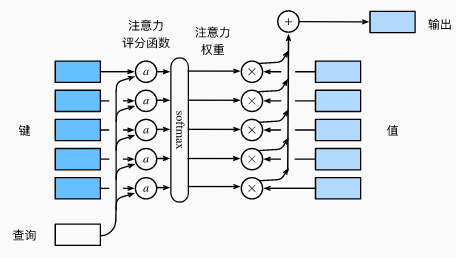
用数学语言来描述：
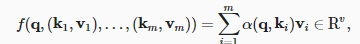
其中查询 q 和键 ki 的注意力权重（标量） 是通过注意力评分函数 a  将两个向量映射成标量， 再经过softmax运算得到的
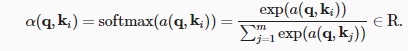


q和k的长度不同: additive attention
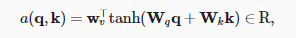
q和k长度相同: scaled dot-product attention
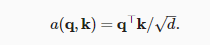
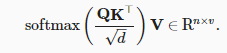


In [25]:
import torch
from torch import nn
import dltools
import math

In [3]:
# 要消除<pad>无意义序列对softmax的影响. 
def masked_softmax(X, valid_lens):
    # X: 3d张量 (batch_size, num_steps, vocab_size), valid_len: 1d或2d的张量
    if valid_lens is None:
        return nn.functional.softmax(X, dim=-1)
    else:
        shape = X.shape
        if valid_lens.dim() == 1:
            valid_lens = torch.repeat_interleave(valid_lens, shape[1])
        else:
            valid_lens = valid_lens.reshape(-1)
            
        # 给一个非常大的负值进行替换. 从而使softmax的输出为0
        X = dltools.sequence_mask(X.reshape(-1, shape[-1]), valid_lens, value=-1e6)
        return nn.functional.softmax(X.reshape(shape), dim=-1)

In [4]:
a = torch.rand(2, 2, 4)
print(a)

tensor([[[0.4093, 0.7093, 0.0761, 0.8702],
         [0.2154, 0.7554, 0.8548, 0.1572]],

        [[0.0996, 0.9739, 0.0709, 0.5982],
         [0.9999, 0.5366, 0.9601, 0.3626]]])


In [5]:
masked_softmax(a, torch.tensor([2, 3]))

tensor([[[0.4256, 0.5744, 0.0000, 0.0000],
         [0.3682, 0.6318, 0.0000, 0.0000]],

        [[0.2289, 0.5487, 0.2224, 0.0000],
         [0.3861, 0.2429, 0.3710, 0.0000]]])

In [6]:
torch.repeat_interleave(torch.tensor([2, 3]), 2)

tensor([2, 2, 3, 3])

In [8]:
a.reshape(-1, 4).reshape(2, 2, 4)

tensor([[[ 4.0932e-01,  7.0931e-01, -1.0000e+06, -1.0000e+06],
         [ 2.1537e-01,  7.5538e-01, -1.0000e+06, -1.0000e+06]],

        [[ 9.9607e-02,  9.7391e-01,  7.0947e-02, -1.0000e+06],
         [ 9.9991e-01,  5.3660e-01,  9.6010e-01, -1.0000e+06]]])

In [21]:
# additive attention
class AdditiveAttention(nn.Module):
    def __init__(self, key_size, query_size, num_hiddens, dropout, **kwargs):
        super().__init__(**kwargs)
        self.W_k = nn.Linear(key_size, num_hiddens, bias=False)
        self.W_q = nn.Linear(query_size, num_hiddens, bias=False)
        self.w_v = nn.Linear(num_hiddens, 1, bias=False)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, queries, keys, values, valid_lens):
        print(queries.shape, keys.shape, values.shape)
        queries, keys = self.W_q(queries), self.W_k(keys)
        print(queries.shape, keys.shape, values.shape)
        features = queries.unsqueeze(2) + keys.unsqueeze(1)
        features = torch.tanh(features)
        scores = self.w_v(features).squeeze(-1)
        print(scores.shape)
        self.attention_weights = masked_softmax(scores, valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), values)

In [22]:
queries, keys = torch.normal(0, 1, (2, 2, 20)), torch.ones((2, 10, 2))
values = torch.arange(40, dtype=torch.float32).reshape(1, 10, 4).repeat(2, 1, 1) # -> [2, 10, 4]
valid_lens = torch.tensor([2, 6])
attention = AdditiveAttention(key_size=2, query_size=20, num_hiddens=8, dropout=0.1)
attention.eval()
attention(queries, keys, values, valid_lens)

torch.Size([2, 2, 20]) torch.Size([2, 10, 2]) torch.Size([2, 10, 4])
torch.Size([2, 2, 8]) torch.Size([2, 10, 8]) torch.Size([2, 10, 4])
torch.Size([2, 2, 10])


tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000],
         [ 2.0000,  3.0000,  4.0000,  5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000],
         [10.0000, 11.0000, 12.0000, 13.0000]]], grad_fn=<BmmBackward0>)

In [20]:
(torch.ones(2, 2, 8).unsqueeze(2) + torch.ones(2, 10, 8).unsqueeze(1)).shape

torch.Size([2, 2, 10, 8])

In [19]:
torch.ones(2, 2, 8).unsqueeze(2).shape

torch.Size([2, 2, 1, 8])

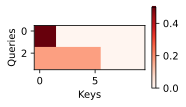

In [24]:
dltools.show_heatmaps(attention.attention_weights.reshape((1, 1, 4, 10)), xlabel='Keys', ylabel='Queries')

In [26]:
# scaled dot_product attention
class DotProductAttention(nn.Module):
    # 缩放点积注意力
    def __init__(self, dropout, **kwargs):
        super().__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, queries, keys, values, valid_lens=None):
        # queries的shape: (batch_size, 查询的个数, 长度(features/d)) 2, 1, 2
        # keys的shape: (batch_size, 键值对的个数, d) 2, 10, 2
        # values的shape: (batch_size, 键值对的个数, 值的features的长度), 2, 10, 4
        # valid_lens的shape: (batch_size), 或者(batch_size, 查询个数)
        d = queries.shape[-1]
        scores = torch.bmm(queries, keys.transpose(1, 2)) / math.sqrt(d) # 2, 1, 10
        print(scores.shape)
        self.attention_weights = masked_softmax(scores, valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), values) # 2, 1, 10, 2, 10, 4 -> 2, 1, 4

In [27]:
queries = torch.normal(0, 1, (2, 1, 2))
attention = DotProductAttention(dropout=0.2)
attention.eval()
attention(queries, keys, values, valid_lens)

torch.Size([2, 1, 10])


tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000]]])

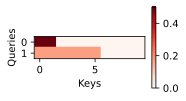

In [29]:
dltools.show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)), xlabel='Keys', ylabel='Queries')